# Importing Packages

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import json

# Opening Files, Converting to DataFrames

In [2]:
bound_df = pd.read_csv('City_Boundary_layer.csv')
camera_df = pd.read_csv('Traffic_Camera_Locations.csv')
signal_df = pd.read_csv('Traffic_Signals.csv')
sign_df = pd.read_csv('Traffic_Signs.csv')
speed_df = pd.read_csv('Speed_Limits.csv')
volume_df = pd.read_csv('Traffic_Volumes_for_2018.csv')

incident_df = pd.read_csv('Traffic_Incidents.csv')
incident_df = incident_df[incident_df.START_DT.str.contains('2018')]

weather_list = []
weather_months = ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12']
for i in weather_months:
    file_in = 'MonthlyWeather\en_climate_hourly_AB_3031092_' + i + '-2018_P1H.csv'
    df =pd.read_csv(file_in)
    weather_list.append(df)

weather_df = pd.concat(weather_list, axis=0, ignore_index=True)

# Cleaning Data

In [3]:
# City Boundaries
# Defining City Boundaries

poly = bound_df['the_geom'][0]

poly = poly.replace('POLYGON ((', '').replace('))', '')
poly = poly.split(',')
for i, s in enumerate(poly):
            poly[i] = s.strip()

bound_df1 = pd.DataFrame(poly, columns=['coords'])
bound_df1[['lon','lat']] = bound_df1['coords'].str.split(' ',expand=True)

north_bd = float(bound_df1['lat'].max())
south_bd = float(bound_df1['lat'].min())
east_bd = float(bound_df1['lon'].min())
west_bd =float( bound_df1['lon'].max())


In [4]:
# Cameras
# Getting coord list for cameras

cam_coord_list = []
for index, row in camera_df.iterrows():
    cam_coords = [float(row['latitude']), float(row['longitude'])]
    cam_coord_list.append(cam_coords)
    
camera_df['coords'] = cam_coord_list

In [5]:
# Signals
# Getting coord list for signals

sig_coord_list = []
for index, row in signal_df.iterrows():
    sig_coords = [float(row['latitude']), float(row['longitude'])]
    sig_coord_list.append(sig_coords)
    
signal_df['coords'] = sig_coord_list

In [6]:
# Signs
# Getting coord list for signs

sin_coord_list = []
for row in sign_df['POINT']:
    sign_point = row
    sign_point = sign_point.replace('POINT ', '').replace('(', '').replace(')', '')
    spl = sign_point.split(' ')
    
    sin_coords = [float(spl[1]), float(spl[0])]
    sin_coord_list.append(sin_coords)
    
sign_df['coords'] = sin_coord_list

In [7]:
# Incidents
# For Incidents, parsing dates, creating coord list
incident_df = incident_df[incident_df.DESCRIPTION.str.contains('incident',case=False)]

incident_df['START_DT'] = pd.to_datetime(incident_df['START_DT'])

inc_coord_list = []
for index, row in incident_df.iterrows():
    inc_coords = [float(row['Latitude']), float(row['Longitude'])]
    inc_coord_list.append(inc_coords)

incident_df['Month'] = pd.DatetimeIndex(incident_df['START_DT']).month
incident_df['Day'] = pd.DatetimeIndex(incident_df['START_DT']).day
incident_df['coords'] = inc_coord_list

In [8]:
# Weather
# Getting daily values for temperature and visibility, combining weather with incidents dataframe

daily_weather = weather_df[['Month', 'Day', 'Temp (°C)', 'Visibility (km)']].groupby(['Month', 'Day']).mean()
incidents_weather_df = pd.merge(incident_df[['Month', 'Day', 'coords']], daily_weather, how='left', left_on=['Month', 'Day'], right_on=['Month', 'Day'])

In [9]:
# Speed Limits
# Getting distances for speed limit sections and creating coord list, cleaning

speed_df = speed_df[speed_df.multiline.str.contains('MULTILINESTRING',case=True)]

spd_coord_list = []
dist_list = []

# For every row in dataframe, break down multiline coords into list of lists
for row in speed_df['multiline']:
    spd_coords = row
    dist_sum = 0
    lon_list = []
    lat_list = []

    # Getting multiline coordinates
    spd_coords = spd_coords.replace('MULTILINESTRING ((', '').replace('))', '').replace(')', '').replace('(', '')
    spd_coords = spd_coords.split(',')
    for i, s in enumerate(spd_coords):
        s = s.strip()
        spl = s.split(' ')
        spd_coords[i] = [float(spl[1]), float(spl[0])]
        lon_list.append(float(spl[0]))
        lat_list.append(float(spl[1]))

    # Summing distance between each coordinate in multiline
    for i in range (1, len(lon_list)):
        dlon = math.radians(lon_list[i]) - math.radians(lon_list[i-1]) 
        dlat = math.radians(lat_list[i]) - math.radians(lat_list[i-1])  
    
        a = math.sin(dlat / 2)**2 + math.cos(math.radians(lat_list[i])) * math.cos(math.radians(lat_list[i-1])) * math.sin(dlon / 2)**2
        c = 2 * math.asin(math.sqrt(a))  

        dist_sum += (c * 6371)
    
    spd_coord_list.append(spd_coords)
    dist_list.append(dist_sum)

speed_df['coords'] = spd_coord_list
speed_df['DISTANCE'] = dist_list

In [10]:
# Traffic Volume
# Making multiline coordinate lists for traffic volumes and cleaning

volume_df = volume_df[volume_df.multilinestring.str.contains('MULTILINESTRING',case=True)]

vol_coord_list = []

# Getting multiline coordinates
for row in volume_df['multilinestring']:
    vol_coords = row

    vol_coords = vol_coords.replace('MULTILINESTRING ((', '').replace('))', '').replace(')', '').replace('(', '')
    vol_coords = vol_coords.split(',')
    for i, s in enumerate(vol_coords):
        s = s.strip()
        spl = s.split(' ')
        vol_coords[i] = [float(spl[1]), float(spl[0])]
    
    vol_coord_list.append(vol_coords)
    
volume_df['coords'] = vol_coord_list

# Creating Map and Grid

In [11]:
# Grid Methods
# createGrid method to makes a 10x10 grid over bounds input
def create_grid(nw, se):
    grids = []
    
    # Getting 10 steps and getting length of steps
    lon_steps = np.linspace(nw_corner[1], se_corner[1], 11)
    lat_steps = np.linspace(nw_corner[0], se_corner[0], 11)
    lon_iters = lon_steps[1] - lon_steps[0]
    lat_iters = lat_steps[1] - lat_steps[0]
    
    # Getting coordinates of bounds of each grid, saving values to JSON
    for lat in lat_steps[:-1]:
        for lon in lon_steps[:-1]:
            nw = [lon, lat]
            ne = [lon + lon_iters, lat]
            sw = [lon, lat + lat_iters]
            se = [lon + lon_iters, lat + lat_iters]
            
            coordinates = [nw, ne, se, sw, nw]
            
            geo_json = {'type': 'FeatureCollection',
                        'properties':{
                            'nw': nw,
                            'se': se
                        },
                        'features':[]}

            grid_feature = {
                'type':'Feature',
                'geometry':{
                    'type':'Polygon',
                    'coordinates': [coordinates],
                }
            }

            geo_json['features'].append(grid_feature)

            grids.append(geo_json)
    
    return grids

# Using similar grids to https://www.jpytr.com/post/analysinggeographicdatawithfolium/

In [12]:
# Value Methods
# Methods to get values within grids
# Gets the number of values between Northwest and Southeast coordinates
def get_single_count(df_in, nw, se):
    grid_count = 0
    for i in df_in['coords']:
        if (i[1] > nw[0] and i[1] < se[0] and i[0] < nw[1] and i[0] > se[1]):
            grid_count += 1

    return grid_count

# Gets the average speed limit between Northwest and Southeast coordinates
# See report for methodolog
def get_avg_speed(df_in, nw, se):
    dist_list = []
    speed_list = []
    
    for index, row in df_in.iterrows():
        for i in row['coords']:
            if (i[1] > nw[0] and i[1] < se[0] and i[0] < nw[1] and i[0] > se[1]):
                dist_list.append(row['DISTANCE'])
                speed_list.append(row['SPEED'])
                break
    
    sum_dist_speed = 0
    for i, s in enumerate(dist_list):
        sum_dist_speed += dist_list[i]*speed_list[i]
    
    if(len(dist_list)>0):    
        return (sum_dist_speed/(sum(dist_list)))
    else:
        return 0

# Gets the average car volume and total road length between Northwest and Southeast coordinates
# See report for methodology
def get_avg_volume(df_in, nw, se):
    dist_list = []
    vol_list = []
    
    for index, row in df_in.iterrows():
        for i in row['coords']:
            if (i[1] > nw[0] and i[1] < se[0] and i[0] < nw[1] and i[0] > se[1]):
                dist_list.append(row['Shape_Leng']/1000)
                vol_list.append(row['VOLUME'])
                break
    
    if(len(dist_list)>0):    
        return (sum(vol_list)/sum(dist_list)), sum(dist_list)
    else:
        return 0, 0

In [13]:
# Creating Map
# Creating folium map with grid on it
grid_map = folium.Map(location=[51.0447, -114.0719], zoom_start=10)

# Creating grids
nw_corner = [north_bd, west_bd]
se_corner = [south_bd, east_bd]
grid = create_grid(nw_corner, se_corner)

# List of popup info to display in grids and list for dataframe for later analysis
popups = []
grid_rows = []

# Populating popup info list and dataframe list
for i, box in enumerate(grid):
    
    # Setting bounds
    nw = box['properties']['nw']
    se = box['properties']['se']
    
    # Getting data
    cameras_grid = get_single_count(camera_df, nw, se)
    signals_grid = get_single_count(signal_df, nw, se)
    signs_grid = get_single_count(sign_df, nw, se)
    incidents_grid = get_single_count(incidents_weather_df, nw, se)
    speed_grid = get_avg_speed(speed_df, nw, se)
    volume_grid, length_grid = get_avg_volume(volume_df, nw, se)
    
    # Formatting popup with html
    html = """<!DOCTYPE html>
        <html>
        <body width='200'>

        <p>Grid #: {:,.0f}</p>
        <p>Total cameras in grid: {:,.0f}</p>
        <p>Total signals in grid: {:,.0f}</p>
        <p>Total signs in grid: {:,.0f}</p>
        <p>Total incidents in grid: {:,.0f}</p>
        <p>Average speed limit in grid (km/h): {:,.0f}</p>
        <p>Average volume in grid (volume/km): {:,.0f}</p>
        <p>Total length of road in grid (km): {:,.0f}</p>

        </body>
        </html>"""
    
    # Appending to popups
    grid_text = folium.Popup(html.format(i, cameras_grid, signals_grid, signs_grid, incidents_grid, speed_grid, volume_grid, length_grid), max_width=200) 
    popups.append(grid_text)
    
    # Appending to dataframe list
    grid_rows.append([i, cameras_grid, signals_grid, signs_grid, incidents_grid, speed_grid, volume_grid, length_grid])

# Displaying grids over map    
for i, geo_json in enumerate(grid):
    grid_child = folium.GeoJson(geo_json, style_function=lambda feature, color='blue': {'fillColor': 'blue', 'color':'black', 'weight': 1, 'dashArray': '5, 5', 'fillOpacity': 0.2,})
    grid_child.add_child(popups[i])
    grid_map.add_child(grid_child)

# Create grid dataframe    
grid_df = pd.DataFrame(grid_rows, columns=['Grid #', 'Total Cameras', 'Total Signals', 'Total Signs', 'Total Incidents', 'Avg. Speed Limit', 'Avg. Volume', 'Road Length'])

# Display map
grid_map

# Incident Analysis

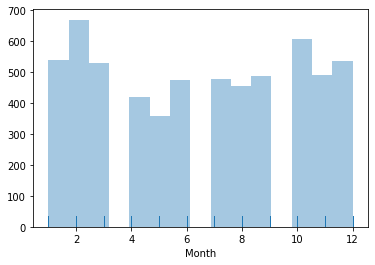

In [14]:
# Monthly Histogram
# Monthly histogram of incidents
sns.distplot(incidents_weather_df['Month'], kde=False, rug=True);

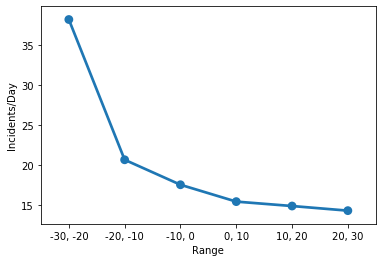

In [15]:
# Temperature Pointplot
# Pointplot of incidents within temperature ranges
# See report for methodology

# Bins, labels, dataframes to be used
temp_bins = [-30, -20, -10, 0, 10, 20, 30]
temp_labels = ['-30, -20', '-20, -10', '-10, 0', '0, 10', '10, 20', '20, 30']
temp_df = incidents_weather_df
daily_temp_df = daily_weather

# Getting count of incidents in each temp range
temp_df['Temp (°C)'] = pd.to_numeric(temp_df['Temp (°C)'])
temp_df['temp_binned'] = pd.cut(temp_df['Temp (°C)'], bins=temp_bins, labels=temp_labels)
temp_count_inc = temp_df.groupby('temp_binned').count()['Day']

# Getting count of days in each temp range
daily_temp_df['Temp (°C)'] = pd.to_numeric(daily_temp_df['Temp (°C)'])
daily_temp_df['temp_binned'] = pd.cut(daily_temp_df['Temp (°C)'], bins=temp_bins, labels=temp_labels)
temp_count_day = daily_temp_df.groupby('temp_binned').count()['Temp (°C)']

# Creating new dataframe with count values
combo_temp_list = []
for i, s in enumerate(temp_labels):
    combo_temp_list.append([temp_labels[i], (temp_count_inc[i]/temp_count_day[i])])

combo_temp_df = pd.DataFrame(combo_temp_list, columns=['Range', 'Incidents/Day'])

# Creating/displaying plot
temp_ratio = sns.pointplot(x='Range',  y='Incidents/Day', data=combo_temp_df)
temp_ratio

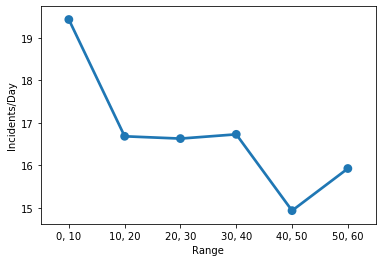

In [16]:
# Visibility Pointplot
# Pointplot of incidents within visibility ranges
# See report for methodology

# Bins, labels, dataframes to be used
vis_bins = [0, 10, 20, 30, 40, 50, 60]
vis_labels = ['0, 10', '10, 20', '20, 30', '30, 40', '40, 50', '50, 60']
vis_df = incidents_weather_df
daily_vis_df = daily_weather

# Getting count of incidents in each visibility range
vis_df['Visibility (km)'] = pd.to_numeric(vis_df['Visibility (km)'])
vis_df['vis_binned'] = pd.cut(vis_df['Visibility (km)'], bins=vis_bins, labels=vis_labels)
vis_count_inc = vis_df.groupby('vis_binned').count()['Day']

# Getting count of days in each visibility range
daily_vis_df['Visibility (km)'] = pd.to_numeric(daily_vis_df['Visibility (km)'])
daily_vis_df['vis_binned'] = pd.cut(daily_vis_df['Visibility (km)'], bins=vis_bins, labels=vis_labels)
vis_count_day = daily_vis_df.groupby('vis_binned').count()['Visibility (km)']

# Creating new dataframe with count values
combo_vis_list = []
for i, s in enumerate(vis_labels):
    combo_vis_list.append([vis_labels[i], (vis_count_inc[i]/vis_count_day[i])])

combo_vis_df = pd.DataFrame(combo_vis_list, columns=['Range', 'Incidents/Day'])

# Creating/displaying plot
vis_ratio = sns.pointplot(x='Range',  y='Incidents/Day', data=combo_vis_df)
vis_ratio

In [17]:
# Grid Plots
# Setting up dataframe for grids and defining spearman calculation methods from Assignment 3
analyze_grid_df = grid_df
analyze_grid_df['Incidents/km'] = analyze_grid_df['Total Incidents']/analyze_grid_df['Road Length']
analyze_grid_df = analyze_grid_df.fillna(0)

def spearman_calc(x_list, y_list):
    """Calculates the Spearman's correlation coefficient from 2 ranked lists input."""

    n = len(x_list)
    d_squared = []

    # Creating a tuple of both lists, calculating their difference squaring it
    for x, y in zip(x_list, y_list):
        diff = x-y
        d_squared.append(math.pow(diff, 2))

    # Calculating Spearman's coefficient
    sum_d_squared = sum(d_squared)
    rho = 1 - (6*sum_d_squared)/(math.pow(n, 3) - n)

    return rho

def compute_list_rank(list_in):
    """Function takes a list input and assigns a rank to each value in it, then
    returns the ranks as a list."""

    list_in_index = list(zip(list_in, range(len(list_in))))  # Creating tuple with first list and its order
    list_in_index_sorted = sorted(list_in_index)             # Sorting the list
    ranks = [0]*len(list_in)                                 # Creating ranks list

    # Assigning the rank of each number sorted to the ranks list
    for i, item in enumerate(list_in_index_sorted):
        ranks[item[1]] = i+1

    return ranks

# Ranking incidents and incidents per km
inc_rank = compute_list_rank(analyze_grid_df['Total Incidents'].to_list())
inc_per_km_rank = compute_list_rank(analyze_grid_df['Incidents/km'].to_list())

Spearman coefficient for Grid # vs Total Incidents:  -0.01711371137113704
Spearman coefficient for Grid # vs Avg. Incidents per km:  -0.04650465046504659


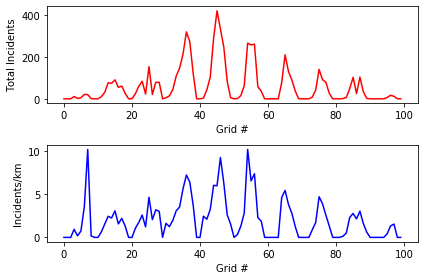

In [18]:
# Grid #
# Plotting Grid # vs Total Incidents and Average Incidents per km of road and getting Spearman coefficient

grids_rank = compute_list_rank(analyze_grid_df['Grid #'].to_list())
print('Spearman coefficient for Grid # vs Total Incidents: ', spearman_calc(grids_rank, inc_rank))
print('Spearman coefficient for Grid # vs Avg. Incidents per km: ', spearman_calc(grids_rank, inc_per_km_rank))


fig, (ax1, ax2) = plt.subplots(nrows=2)
grid_vs_total = sns.lineplot(x='Grid #', y='Total Incidents', data=analyze_grid_df, ci=None, color='red', ax=ax1)
grid_vs_avg = sns.lineplot(x='Grid #', y='Incidents/km', data=analyze_grid_df, ci=None, color='blue', ax=ax2)
plt.tight_layout()

Spearman coefficient for Total Cameras vs Total Incidents:  0.6844164416441645
Spearman coefficient for Total Cameras vs Avg. Incidents per km:  0.5962436243624363


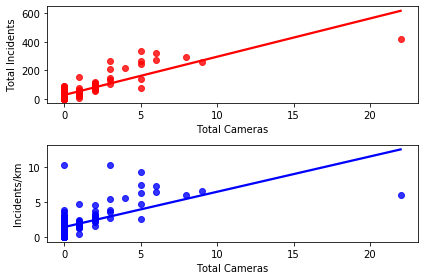

In [19]:
# Cameras
# Plotting Total Cameras vs Total Incidents and Average Incidents per km of road and getting Spearman coefficient

cameras_rank = compute_list_rank(analyze_grid_df['Total Cameras'].to_list())
print('Spearman coefficient for Total Cameras vs Total Incidents: ', spearman_calc(cameras_rank, inc_rank))
print('Spearman coefficient for Total Cameras vs Avg. Incidents per km: ', spearman_calc(cameras_rank, inc_per_km_rank))

fig, (ax1, ax2) = plt.subplots(nrows=2)
grid_vs_total = sns.regplot(x='Total Cameras', y='Total Incidents', data=analyze_grid_df, ci=None, color='red', ax=ax1)
grid_vs_avg = sns.regplot(x='Total Cameras', y='Incidents/km', data=analyze_grid_df, ci=None, color='blue', ax=ax2)
plt.tight_layout()

Spearman coefficient for Total Signals vs Total Incidents:  0.9206960696069607
Spearman coefficient for Total Signals vs Avg. Incidents per km:  0.8196819681968197


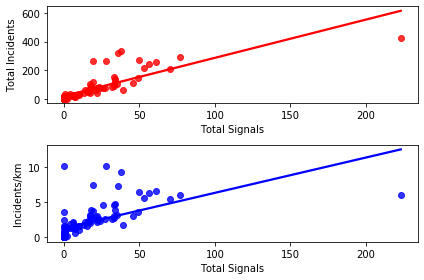

In [20]:
# Signals
# Plotting Total Signals vs Total Incidents and Average Incidents per km of road and getting Spearman coefficient

signals_rank = compute_list_rank(analyze_grid_df['Total Signals'].to_list())
print('Spearman coefficient for Total Signals vs Total Incidents: ', spearman_calc(signals_rank, inc_rank))
print('Spearman coefficient for Total Signals vs Avg. Incidents per km: ', spearman_calc(signals_rank, inc_per_km_rank))

fig, (ax1, ax2) = plt.subplots(nrows=2)
grid_vs_total = sns.regplot(x='Total Signals', y='Total Incidents', data=analyze_grid_df, ci=None, color='red', ax=ax1)
grid_vs_avg = sns.regplot(x='Total Signals', y='Incidents/km', data=analyze_grid_df, ci=None, color='blue', ax=ax2)
plt.tight_layout()

Spearman coefficient for Total Signs vs Total Incidents:  0.9213561356135613
Spearman coefficient for Total Signs vs Avg. Incidents per km:  0.8513051305130513


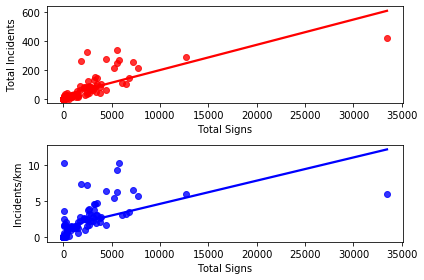

In [21]:
# Signs
# Plotting Total Signs vs Total Incidents and Average Incidents per km of road and getting Spearman coefficient

signs_rank = compute_list_rank(analyze_grid_df['Total Signs'].to_list())
print('Spearman coefficient for Total Signs vs Total Incidents: ', spearman_calc(signs_rank, inc_rank))
print('Spearman coefficient for Total Signs vs Avg. Incidents per km: ', spearman_calc(signs_rank, inc_per_km_rank))

fig, (ax1, ax2) = plt.subplots(nrows=2)
grid_vs_total = sns.regplot(x='Total Signs', y='Total Incidents', data=analyze_grid_df, ci=None, color='red', ax=ax1)
grid_vs_avg = sns.regplot(x='Total Signs', y='Incidents/km', data=analyze_grid_df, ci=None, color='blue', ax=ax2)
plt.tight_layout()

Spearman coefficient for Avg. Speed Limit vs Total Incidents:  0.5047104710471046
Spearman coefficient for Avg. Speed Limit vs Avg. Incidents per km:  0.5306930693069307


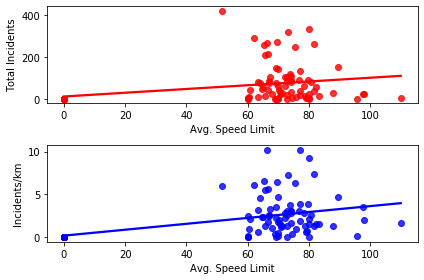

In [22]:
# Speed Limits
# Plotting Average Speed Limit vs Total Incidents and Average Incidents per km of road and getting Spearman coefficient

speed_rank = compute_list_rank(analyze_grid_df['Avg. Speed Limit'].to_list())
print('Spearman coefficient for Avg. Speed Limit vs Total Incidents: ', spearman_calc(speed_rank, inc_rank))
print('Spearman coefficient for Avg. Speed Limit vs Avg. Incidents per km: ', spearman_calc(speed_rank, inc_per_km_rank))

fig, (ax1, ax2) = plt.subplots(nrows=2)
grid_vs_total = sns.regplot(x='Avg. Speed Limit', y='Total Incidents', data=analyze_grid_df, ci=None, color='red', ax=ax1)
grid_vs_avg = sns.regplot(x='Avg. Speed Limit', y='Incidents/km', data=analyze_grid_df, ci=None, color='blue', ax=ax2)
plt.tight_layout()

Spearman coefficient for Avg. Volume vs Total Incidents:  0.92
Spearman coefficient for Avg. Volume vs Avg. Incidents per km:  0.9228922892289229


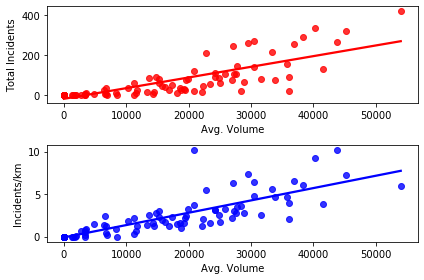

In [23]:
# Traffic Volumes
# Plotting Average Volume vs Total Incidents and Average Incidents per km of road and getting Spearman coefficient

volume_rank = compute_list_rank(analyze_grid_df['Avg. Volume'].to_list())
print('Spearman coefficient for Avg. Volume vs Total Incidents: ', spearman_calc(volume_rank, inc_rank))
print('Spearman coefficient for Avg. Volume vs Avg. Incidents per km: ', spearman_calc(volume_rank, inc_per_km_rank))

fig, (ax1, ax2) = plt.subplots(nrows=2)
grid_vs_total = sns.regplot(x='Avg. Volume', y='Total Incidents', data=analyze_grid_df, ci=None, color='red', ax=ax1)
grid_vs_avg = sns.regplot(x='Avg. Volume', y='Incidents/km', data=analyze_grid_df, ci=None, color='blue', ax=ax2)
plt.tight_layout()

In [24]:
# Traffic Volumes
# Checking Spearman coefficient of Average Volume vs Total Cameras, Signals and Signs

print('Spearman coefficient for Avg. Volume vs Total Cameras: ', spearman_calc(volume_rank, cameras_rank))
print('Spearman coefficient for Avg. Volume vs Total Signals: ', spearman_calc(volume_rank, signals_rank))
print('Spearman coefficient for Avg. Volume vs Total Signs: ', spearman_calc(volume_rank, signs_rank))

Spearman coefficient for Avg. Volume vs Total Cameras:  0.5795619561956196
Spearman coefficient for Avg. Volume vs Total Signals:  0.8174977497749775
Spearman coefficient for Avg. Volume vs Total Signs:  0.8811761176117612


# Visualization

In [25]:
# Speed Map
# Creating map with speeds on roads

# List of unique speeds and corresponding colours
speeds_list = sorted(speed_df['SPEED'].unique().tolist())
colours_list = ['#FF0000', '#FF2300', '#FF4600', '#FF6900','#FF9E00', '#FFC100', '#FFE400', '#F7FF00', '#D4FF00', '#B0FF00', '#8DFF00']

# Create new map
speed_map = folium.Map(location=[51.0447, -114.0719], zoom_start=10, tiles='cartodbpositron')

# Adding polylines of roads using coordinates, colour coded
for index, row in speed_df.iterrows():
    for i, s in enumerate(speeds_list):
        if(s == row['SPEED']):
            colour = colours_list[i]
    
    folium.PolyLine(row['coords'], color=colour, weight=2.5, opacity=1).add_to(speed_map)

In [26]:
# Speed Map
# Adding legend to map
# Legend template from https://nbviewer.jupyter.org/gist/talbertc-usgs/18f8901fc98f109f2b71156cf3ac8
from branca.element import Template, MacroElement

template = """
{% macro html(this, kwargs) %}

<!doctype html>
<html lang="en">
<head>
  <meta charset="utf-8">
  <meta name="viewport" content="width=device-width, initial-scale=1">
  <title>jQuery UI Draggable - Default functionality</title>
  <link rel="stylesheet" href="//code.jquery.com/ui/1.12.1/themes/base/jquery-ui.css">

  <script src="https://code.jquery.com/jquery-1.12.4.js"></script>
  <script src="https://code.jquery.com/ui/1.12.1/jquery-ui.js"></script>
  
  <script>
  $( function() {
    $( "#maplegend" ).draggable({
                    start: function (event, ui) {
                        $(this).css({
                            right: "auto",
                            top: "auto",
                            bottom: "auto"
                        });
                    }
                });
});

  </script>
</head>
<body>

 
<div id='maplegend' class='maplegend' 
    style='position: absolute; z-index:9999; border:2px solid grey; background-color:rgba(255, 255, 255, 0.8);
     border-radius:6px; padding: 10px; font-size:14px; right: 20px; bottom: 20px;'>
     
<div class='legend-title'>Speeds in km/h</div>
<div class='legend-scale'>
  <ul class='legend-labels'>
    <li><span style='background:#FF0000;opacity:1;'></span>20</li>
    <li><span style='background:#FF2300;opacity:1;'></span>30</li>
    <li><span style='background:#FF4600;opacity:1;'></span>35</li>
    <li><span style='background:#FF6900;opacity:1;'></span>40</li>
    <li><span style='background:#FF9E00;opacity:1;'></span>50</li>
    <li><span style='background:#FFC100;opacity:1;'></span>60</li>
    <li><span style='background:#FFE400;opacity:1;'></span>70</li>
    <li><span style='background:#F7FF00;opacity:1;'></span>80</li>
    <li><span style='background:#D4FF00;opacity:1;'></span>90</li>
    <li><span style='background:#B0FF00;opacity:1;'></span>100</li>
    <li><span style='background:#8DFF00;opacity:1;'></span>110</li>

  </ul>
</div>
</div>
 
</body>
</html>

<style type='text/css'>
  .maplegend .legend-title {
    text-align: left;
    margin-bottom: 5px;
    font-weight: bold;
    font-size: 90%;
    }
  .maplegend .legend-scale ul {
    margin: 0;
    margin-bottom: 5px;
    padding: 0;
    float: left;
    list-style: none;
    }
  .maplegend .legend-scale ul li {
    font-size: 80%;
    list-style: none;
    margin-left: 0;
    line-height: 18px;
    margin-bottom: 2px;
    }
  .maplegend ul.legend-labels li span {
    display: block;
    float: left;
    height: 16px;
    width: 30px;
    margin-right: 5px;
    margin-left: 0;
    border: 1px solid #999;
    }
  .maplegend .legend-source {
    font-size: 80%;
    color: #777;
    clear: both;
    }
  .maplegend a {
    color: #777;
    }
</style>
{% endmacro %}"""


# Adding legend to map
macro = MacroElement()
macro._template = Template(template)
speed_map.get_root().add_child(macro)

# Displaying map
speed_map

In [27]:
# Heatmap
# Creating traffic volume Heatmap

from folium import plugins
from folium.plugins import HeatMap

# Create map
heat_map = folium.Map(location=[51.0447, -114.0719], zoom_start=10, tiles='cartodbpositron')

# Getting volume data in coordinates
heat_data = []
for index, row in volume_df.iterrows():
    for s in row['coords']:
        heat_list = [s[0], s[1], row['VOLUME']]
        heat_data.append(heat_list)

# Adding heat to map, displaying map    
heat_map.add_child(HeatMap(heat_data, radius = 10))
heat_map